In [3]:
import glob
import numpy as np
import scipy.optimize as opt
import scipy.signal as sig
import scipy.special as sf
import matplotlib.pyplot as plt

## Data

During each run, resistance of the sample and stage thermistors was gathered using the digital-programmable Keithley 2000 multimeters. This was converted to temperature using a spline. Instruments were controlled and data recorded using a MATLAB script. The first line of each `.csv` file is a header including the date and time of the experiment, the setpoint thermistor resistance, and the equilibriation time and heating time in seconds.

The first column of data is time and the second is temperature in Celsius.

In [5]:
runs = glob.glob("./Runs/*.csv")


# Runs where the sample temperature was still changing when the heating cycle began
# are listed so they can be included or excluded during analysis.
non_equilibrium = ["2025-03-06 16-16-54",
                   "2025-03-06 16-41-58",
                   "2025-03-18 16-08-03",
                   "2025-03-18 17-18-14",
                  ]

# Runs subject to major experimental problems can be excluded by date and time.
exclude = ["2025-03-18 13-28-17", # Drift
           "2025-03-18 13-46-52", # Drift
           "2025-03-18 16-45-25", # Refrigerator driven
           "2025-03-18 17-06-00", # Hysteresis?
           "2025-03-20 15-17-26", # step change
           "2025-03-20 16-03-30", # Refrigerator driven (might be okay)
           "2025-03-27 14-37-32", # Stage went wild
          ] #+ non_equilibrium

n = len(runs) - len(exclude)

included = []

In [6]:
t1 = np.zeros(n) # Array of equlilibriation times of each run
t2 = np.zeros(n) # Array of heating times of each run
Setpoints = np.zeros(n) # Array of thermistor resistance setpoints for each run

In [7]:
times = []
stage_temps = []
sample_temps = []
i = 0
for r in runs:
    with open(r) as f:
        header = f.readline()
        
    elements = header.split()

    if(not((elements[0] + ' ' + elements[1]) in exclude)):
        included.append(r)        
        
        t1[i] = int(elements[4])
        t2[i] = int(elements[6])
        Setpoints[i] = int(elements[2])
        
        time, stage, sample = np.loadtxt(r, delimiter = ',', skiprows = 1, unpack = True)
        times.append(time)
        stage_temps.append(stage)
        sample_temps.append(sample)
        i += 1

In [8]:
# Finding the change in temperature dT divided by the energy input
V = 9 # Volts
I = 34.54 # mA

In [9]:
temp_deltas = []

# to account for slow drift in stage temperature.
for i in range(n):
    temp_deltas.append(sample_temps[i] - stage_temps[i])


In [10]:
# Fitting relaxation times

F = lambda t, t0, A, Tf, tau: Tf + A * np.exp(-(t - t0) / tau)

delay = 90 # additional time to wait after heating ends for transient effects to die down.

A = np.zeros(n) # only recorded for the production of graphs.
tau = np.zeros(n)
tau_sig = np.zeros(n)
T_ss = np.zeros(n)
T_ss_sig = np.zeros(n)

for i in range(n):
    t0 = t1[i] + t2[i] + delay
    F_prime = lambda t, A, Tf, tau: F(t, t0, A, Tf, tau)
    indices = times[i] > t0
    p0 = [1, sample_temps[i][-1], 150] # initial guess for parameters
    P, cov = opt.curve_fit(F_prime, times[i][indices], sample_temps[i][indices], p0 = p0)
    A[i], T_ss[i], tau[i] = P
    _, T_ss_sig[i], tau_sig[i] = np.sqrt(np.diag(cov))

In [11]:
# Fitting relaxation times

A_ = np.zeros(n) # only recorded for the production of graphs.
tau_ = np.zeros(n)
tau_sig_ = np.zeros(n)
T_ss_ = np.zeros(n)
T_ss_sig_ = np.zeros(n)

for i in range(n):
    t0 = t1[i] + t2[i] + delay
    F_prime = lambda t, A_, Tf, tau_: F(t, t0, A_, Tf, tau_)
    indices = times[i] > t0
    p0 = [1, sample_temps[i][-1], 150] # initial guess for parameters
    P, cov = opt.curve_fit(F_prime, times[i][indices], temp_deltas[i][indices], p0 = p0)
    A_[i], T_ss_[i], tau_[i] = P
    _, T_ss_sig_[i], tau_sig_[i] = np.sqrt(np.diag(cov))

(0.0, 500.0)

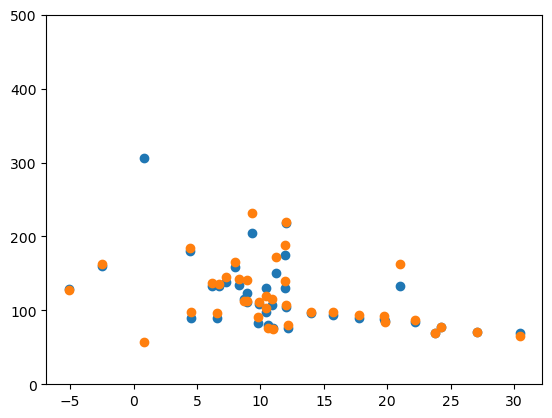

In [12]:
plt.scatter(T_ss, tau)
plt.scatter(T_ss, tau_)

plt.ylim(0, 500)

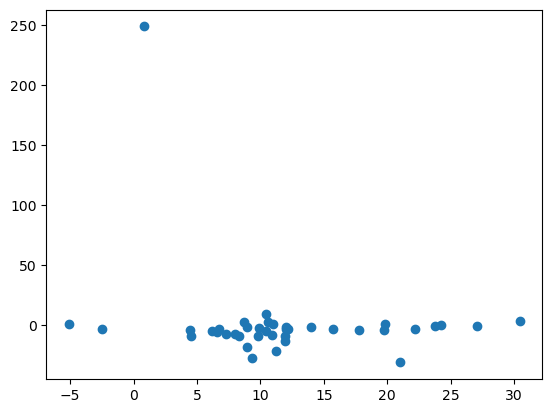

In [13]:
plt.scatter(T_ss, (tau - tau_))

In [14]:
T_ss

array([19.73699179, 19.78423567, 22.21498658, 17.79733006, 15.70846905,
       14.02017324, 11.93258419,  8.96303207,  6.56327017,  4.51168887,
       11.23133267,  8.29232644, 23.77961059, 30.44561033, 27.08659723,
       24.20350245, 21.02926086, 11.8983446 , 10.99668098, 10.59112679,
       10.40762764,  9.31838734,  7.97736672,  7.30284184,  6.71522247,
        6.18922891,  8.67270341,  9.8288637 , 10.4349525 , 12.194842  ,
       12.00558206,  4.42050412,  0.82989073, -2.46408639, -5.09873505,
       11.99436853, 10.90101421,  9.88083463,  8.90733665])

Text(0, 0.5, 'Steady-State Temperature Difference')

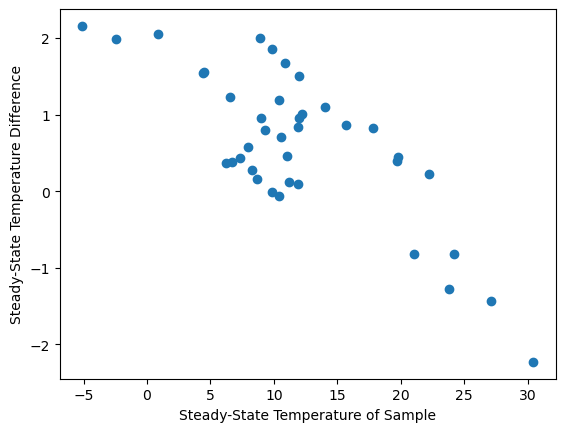

In [43]:
plt.scatter(T_ss, T_ss_)
plt.xlabel("Steady-State Temperature of Sample")
plt.ylabel("Steady-State Temperature Difference")

(array([1., 1., 1., 2., 1., 9., 7., 8., 4., 5.]),
 array([-2.23110635, -1.79216411, -1.35322188, -0.91427964, -0.4753374 ,
        -0.03639517,  0.40254707,  0.8414893 ,  1.28043154,  1.71937378,
         2.15831601]),
 <BarContainer object of 10 artists>)

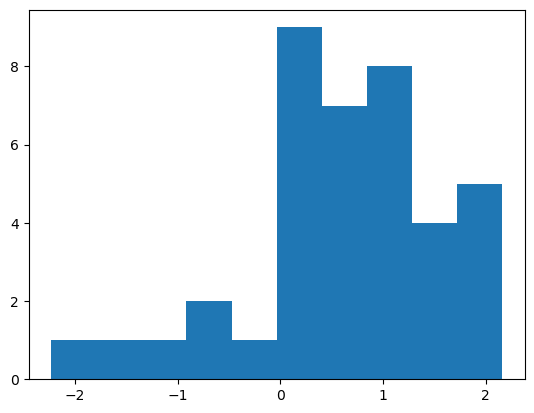

In [36]:
plt.hist(T_ss_)

./Runs\2025-03-25 14-04-43 3500.csv


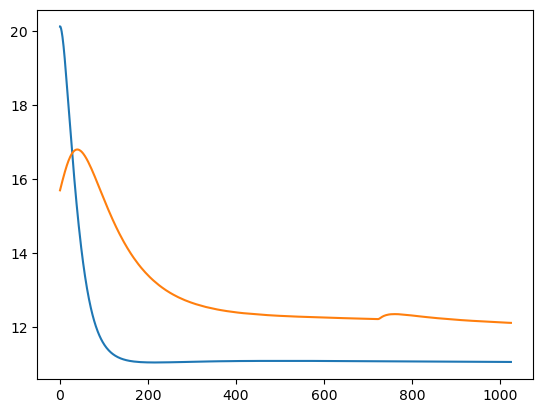

In [18]:
## TESTING CELL
select = 30
print(included[select])

plt.plot(times[select], stage_temps[select])
plt.plot(times[select], sample_temps[select])
#plt.plot(times[select], temp_deltas[select])
#plt.plot(times[select], sample_temps[select] - T_ss[select] + 2)
t0 = t1[select] + t2[select] + delay
X = np.linspace(t0, t0 + 480, 600)
#plt.plot(X, F(X, t0, A_[select], T_ss_[select], tau_[select]), "--")
#plt.axhline(T_ss_[select], color = "green", alpha = 0.3)
#plt.ylim(T_ss[select] - 1, T_ss[select] + 0.5)
#plt.ylim(1, 3)